In [2]:
import numpy as np
class Denoisingautoencoder:
    
    def __init__(self,X_real,hidden_dim):
        self.input_dim = X_real.shape[0]
        self.hidden_dim = hidden_dim
        self.output_dim = X_real.shape[0]
        self.weights_input_hidden = np.random.randn(self.hidden_dim,self.input_dim)*np.sqrt(2/self.input_dim)
        
        # *np.sqrt(2/self.layer_sizes[i]))
        
        self.momentum_input_hidden=np.zeros((self.hidden_dim,self.input_dim))
        
        
        self.bias_input_hidden=np.zeros((self.hidden_dim,1))
        self.bias_hidden_output=np.zeros((self.output_dim,1))
        self.bias_hidden_output_momentum=np.zeros((self.output_dim,1))
        self.bias_input_hidden_momentum=np.zeros((self.hidden_dim,1))
        
    def sigmoid(self,z):
         
        z=np.clip(z, -500, 500)
        return 1/(1+np.exp(-z))
    
    def relu(self,z):
        return np.maximum(0,z)
    
    def relu_derivative(self,z):
        return np.where(z>0,1,0)
    
    def sigmoid_derivative(self,a):
        return a*(1-a)
    
    def lossfunction(self,a,X,lamb=0.01):
        
        eps = 1e-10
        cross_entropy=-np.mean(X*np.log(a + eps)+(1-X)*np.log(1-a + eps))
        l2_reg=lamb*np.sum(self.weights_input_hidden**2)
        return cross_entropy+l2_reg
    
    

    
        
    def forward(self,X):
        
        z1=self.weights_input_hidden@X+self.bias_input_hidden
        a1=self.relu(z1)
        z2=self.weights_input_hidden.T@a1+self.bias_hidden_output
        a2=self.sigmoid(z2)
        
        return z1,a1,z2,a2
    
  
    def derivative_lossfunction(self,a,X):
        eps = 1e-10
        return -X/a+(1-X)/(1-a+eps)

    def backward(self,a2,z2,a1,z1,X_real,X_noise,lamb=0.01):
       
        da2=self.derivative_lossfunction(a2,X_real)
        dz2=self.sigmoid_derivative(a2)*da2
        
        dw2=dz2@a1.T/self.input_dim
        
        db2=np.sum(dz2,axis=1,keepdims=True)/self.input_dim
        da1=self.weights_input_hidden@dz2
        dz1=self.relu_derivative(z1)*da1
         
        dw1=dz1@X_noise.T/self.input_dim+(((2*lamb)/self.input_dim)*self.weights_input_hidden)
        db1=np.sum(dz1,axis=1,keepdims=True)/self.input_dim
        
        
        return dw1,db1,dw2,db2
     
    
    def update_weights(self, learning_rate,momentum_rate,a2,z2,a1,z1,lamb,X_real,X_noise):
        
        self.momentum_input_hidden = momentum_rate * self.momentum_input_hidden
        self.bias_input_hidden_momentum = momentum_rate * self.bias_input_hidden_momentum
        self.bias_hidden_output_momentum = momentum_rate * self.bias_hidden_output_momentum
        
        weights_input_hidden_new = self.weights_input_hidden 
        bias_input_hidden_new = self.bias_input_hidden 
        bias_hidden_output_new = self.bias_hidden_output 
        
        self.weights_input_hidden = self.weights_input_hidden-self.momentum_input_hidden
        self.bias_input_hidden = self.bias_input_hidden-self.bias_input_hidden_momentum
        self.bias_hidden_output = self.bias_hidden_output-self.bias_hidden_output_momentum
        
        dw1,db1,dw2,db2=self.backward(a2,z2,a1,z1,X_real,X_noise,lamb)

        self.momentum_input_hidden +=  learning_rate * (dw1+dw2.T)
        self.bias_input_hidden_momentum += learning_rate * db1
        self.bias_hidden_output_momentum +=  learning_rate * db2
        
        self.weights_input_hidden = weights_input_hidden_new-self.momentum_input_hidden
        self.bias_input_hidden = bias_input_hidden_new-self.bias_input_hidden_momentum
        self.bias_hidden_output = bias_hidden_output_new-self.bias_hidden_output_momentum
        
        
        
        

       
        
        
        
        
        
    def train(self,X,epochs,learning_rate,momentum_rate,lamb,X_real,X_noise):
        for i in range(epochs):
            z1,a1,z2,a2=self.forward(X_noise)
            
            self.update_weights(learning_rate,momentum_rate,a2,z2,a1,z1,lamb,X_real,X_noise)
            
            if i % 10 == 0:
                print(f"Epoch {i} loss: {self.lossfunction(a2,X_real,lamb)}")
                print(self.weights_input_hidden[0:2,0:2])
            
            
            
            
    def predict(self,X):
        z1,a1,z2,a2=self.forward(X)
        return a2


In [3]:

from sklearn.datasets import fetch_openml
import numpy as np

# Load MNIST
mnist = fetch_openml('mnist_784', version=1)
X = mnist.data.values / 255.0  # Normalize to [0,1]
X = X.T  # Now shape is (784, num_samples)



In [4]:
# Create a binary mask with probability 0.5
mask = np.random.binomial(1, 0.5, size=X.shape)

# Apply the mask to create noisy data
X_noisy = X * mask
X_real=X

In [14]:
# Create and train the denoising autoencoder
hidden_dim = 120 # Number of neurons in hidden layer
dae = Denoisingautoencoder(X, hidden_dim)

# Train the model
epochs = 100
learning_rate = 0.0001
momentum_rate = 0.9
lamb = 0.0001  # L2 regularization parameter

dae.train(X, epochs, learning_rate, momentum_rate, lamb, X_real, X_noisy)

# Test the model on some noisy samples
test_samples = 5
test_indices = np.random.randint(0, X.shape[1], test_samples)
X_test = X_noisy[:, test_indices]
X_test_real = X_real[:, test_indices]

# Get predictions
X_pred = dae.predict(X_test)

# Print shapes to verify
print(f"Test samples shape: {X_test.shape}")
print(f"Predictions shape: {X_pred.shape}")


Epoch 0 loss: 0.7170981327185628
[[ 0.02694664 -0.01667766]
 [-0.01354112 -0.00280176]]
Epoch 10 loss: 0.37912669842620284
[[-0.06725139 -0.09732994]
 [-0.02889416 -0.01713498]]
Epoch 20 loss: 0.28016890235420305
[[-0.1501203  -0.16793031]
 [-0.0406981  -0.02840371]]
Epoch 30 loss: 0.2648721477870644
[[-0.18078647 -0.19468641]
 [-0.04539466 -0.03311454]]
Epoch 40 loss: 0.2585850787998283
[[-0.19194765 -0.20491738]
 [-0.04708167 -0.03488046]]
Epoch 50 loss: 0.2537626658518734
[[-0.19606428 -0.2091113 ]
 [-0.04769211 -0.03557853]]
Epoch 60 loss: 0.2503804948866902
[[-0.19763606 -0.21100231]
 [-0.04792861 -0.03592045]]
Epoch 70 loss: 0.24825685208797982
[[-0.19826254 -0.21191581]
 [-0.04803203 -0.03613037]]
Epoch 80 loss: 0.24713550120095684
[[-0.19853241 -0.21240888]
 [-0.04808513 -0.03627894]]
Epoch 90 loss: 0.24658219144847998
[[-0.1986626  -0.21271119]
 [-0.04811792 -0.03639496]]
Test samples shape: (784, 5)
Predictions shape: (784, 5)


In [15]:
weights=dae.weights_input_hidden

mean_weights=np.mean(weights,axis=0)

weights_std=np.std(weights,axis=0)

weights_normalized=weights-mean_weights/weights_std






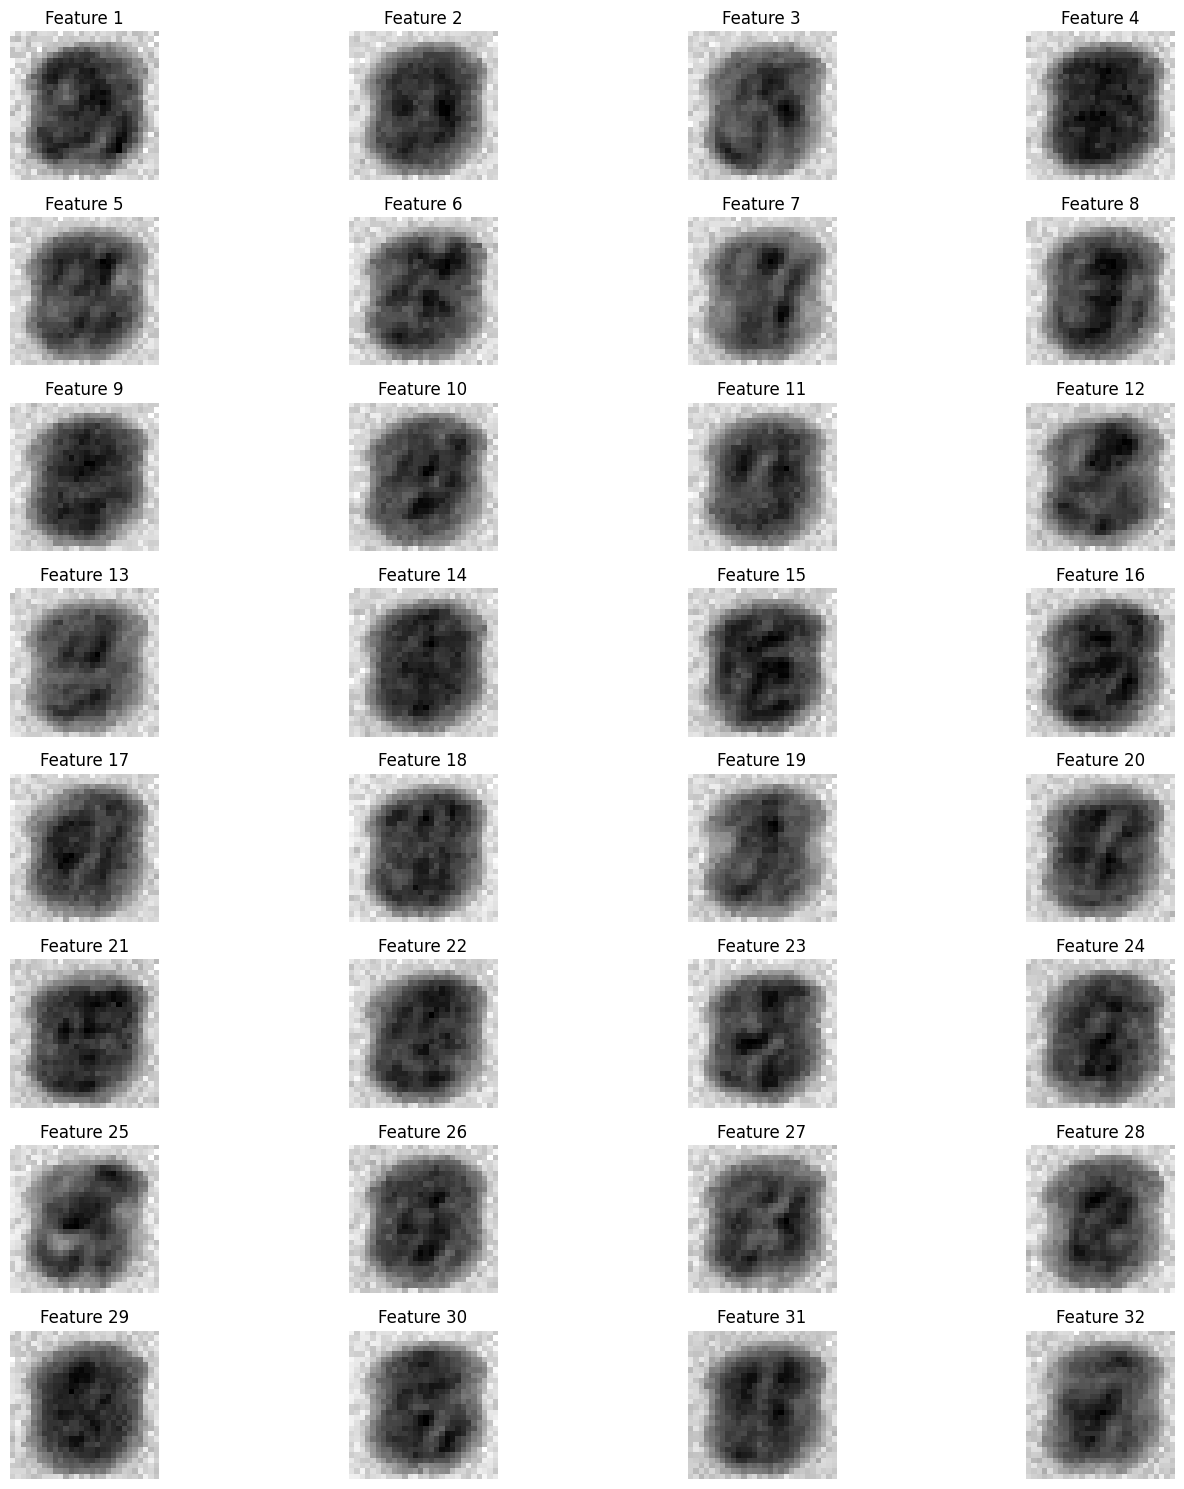

In [18]:
import matplotlib.pyplot as plt

# Reshape each row of weights into 28x28 images
weights_reshaped = weights_normalized.reshape(120, 28, 28)

# Create a figure with a grid of 32 images
plt.figure(figsize=(15, 15))
for i in range(32):
    plt.subplot(8, 4, i+1)  # 8 rows, 4 columns
    plt.imshow(weights_reshaped[i], cmap='gray')
    plt.axis('off')
    plt.title(f'Feature {i+1}')

plt.tight_layout()
plt.show()

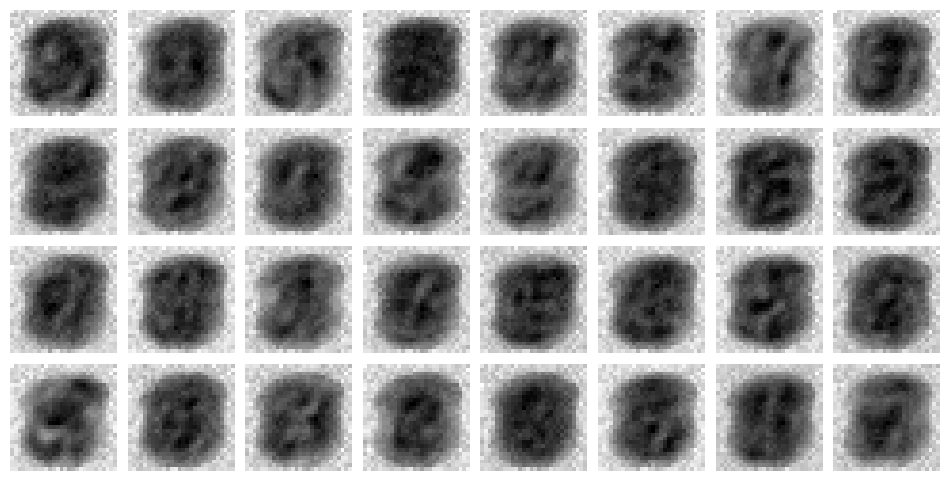

In [19]:
import matplotlib.pyplot as plt

# weights_normalized: shape (32, 784)
weights_reshaped = weights_normalized.reshape(120, 28, 28)

fig, axes = plt.subplots(4, 8, figsize=(12, 6))  # 4 rows, 8 columns for 32 images
for i, ax in enumerate(axes.flat):
    ax.imshow(weights_reshaped[i], cmap='gray', interpolation='nearest')
    ax.axis('off')
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

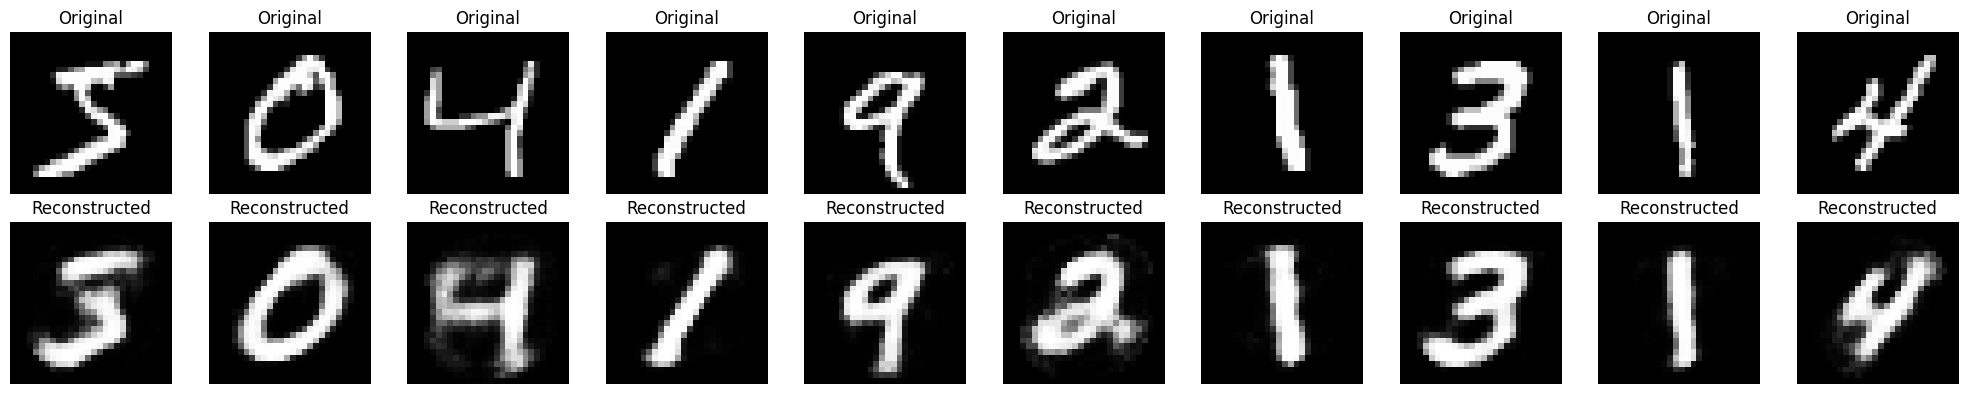

In [21]:
# Get first 10 images and their reconstructions
test_images = X_real[:,:10]
reconstructed_images = dae.predict(test_images)

# Create a figure with 2 rows (original and reconstructed) and 10 columns
plt.figure(figsize=(20, 4))

# Plot original images
for i in range(10):
    plt.subplot(2, 10, i + 1)
    plt.imshow(test_images[:,i].reshape(28, 28), cmap='gray')
    plt.axis('off')
    plt.title('Original')

# Plot reconstructed images
for i in range(10):
    plt.subplot(2, 10, i + 11)
    plt.imshow(reconstructed_images[:,i].reshape(28, 28), cmap='gray')
    plt.axis('off')
    plt.title('Reconstructed')

plt.tight_layout()
plt.show()
